In [ ]:
!unzip /content/drive/MyDrive/Licenta/NEGATIVE.zip  -d /content
!unzip /content/drive/MyDrive/Licenta/POSITIVE.zip  -d /content
!unzip /content/drive/MyDrive/Licenta/POSITIVEGAN.zip  -d /content/content/Licenta/Processed_RSNA2

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/29087_951624387.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/28959_407797154.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/46144_112792357.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/21304_1273578482.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/2516_992751859.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/2182_2067189673.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/6685_2127534398.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/28914_1080307280.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/43539_765637762.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/44626_1988104905.png  
  inflating: /content/content/Licenta/Processed_RSNA2/NEGATIVE/11107_1843457717.png  
  inflating

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split



data_dir = '/content/content/Licenta/Processed_RSNA2/'

# Get list of all image file paths
image_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.png'):
            image_paths.append(os.path.join(root, file))

# Generate labels from file paths
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Split data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.1) #, random_state=40

# Split training data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25) #, random_state=40

# Create a DataFrame to store the file paths and labels
train_df = pd.DataFrame({
    'path': train_paths,
    'label': train_labels
})
val_df = pd.DataFrame({
    'path': val_paths,
    'label': val_labels
})
test_df = pd.DataFrame({
    'path': test_paths,
    'label': test_labels
})

# Print number of images in each set
print(f'Training set: {len(train_df)} images')
print(f'Validation set: {len(val_df)} images')
print(f'Test set: {len(test_df)} images')

Training set: 38931 images
Validation set: 12978 images
Test set: 5768 images


In [ ]:
print(train_df)

                                                   path     label
0     /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
1     /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
2     /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
3     /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
4     /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
...                                                 ...       ...
8497  /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
8498  /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
8499  /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
8500  /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE
8501  /content/content/Licenta/Processed_RSNA2/LCC/N...  NEGATIVE

[8502 rows x 2 columns]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',

)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)


print(f'Training set: {len(train_df)} images')
print(f'Validation set: {len(val_df)} images')
print(f'Test set: {len(test_df)} images')


Found 38931 validated image filenames belonging to 2 classes.
Found 12978 validated image filenames belonging to 2 classes.
Found 5768 validated image filenames belonging to 2 classes.
Training set: 38931 images
Validation set: 12978 images
Test set: 5768 images


In [ ]:
print(train_df['label'].value_counts())

NEGATIVE    36115
POSITIVE     2816
Name: label, dtype: int64


In [ ]:
# Step 1: Încărcarea căilor pozelor generate cu GAN
additional_positive_data_dir = '/content/POSITIVE'
additional_positive_image_paths = []
for file in os.listdir(additional_positive_data_dir):
    if file.endswith('.png'):
        additional_positive_image_paths.append(os.path.join(additional_positive_data_dir, file))

# Step 2: Crearea unui nou dataframe
additional_positive_df = pd.DataFrame({
    'path': additional_positive_image_paths,
    'label': ['POSITIVE'] * len(additional_positive_image_paths)
})

# Step 3: Concatenarea dataframe-ului nou cu cel vechi
train_df = pd.concat([train_df, additional_positive_df], axis=0)

# Amestecarea datelor
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(train_df_augmented['label'].value_counts())

POSITIVE    11662
NEGATIVE    10948
Name: label, dtype: int64


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


def create_model():
    model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256,256,1))
    x = model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = Flatten()(x)
    # x = Dropout(0.40)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=x)

    return model


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the random under sampler
rus = RandomUnderSampler(sampling_strategy=1)

# Fit the random under sampler and obtain a balanced validation set
X_val_res, y_val_res = rus.fit_resample(val_df[['path']], val_df['label'])

# Create a new balanced validation dataframe
val_df_balanced = pd.DataFrame({
    'path': X_val_res['path'],
    'label': y_val_res
})

# Then create your validation generator with the balanced validation dataframe
val_generator = test_datagen.flow_from_dataframe(
    val_df_balanced,
    x_col='path',
    y_col='label',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)

import numpy as np

# Get the labels from the validation generator
labels = val_generator.labels

# Count the occurrences of each unique label
unique, counts = np.unique(labels, return_counts=True)

# Display the counts
label_counts = dict(zip(unique, counts))
print(label_counts)

Found 508 validated image filenames belonging to 2 classes.
{0: 255, 1: 253}


In [ ]:
import tensorflow as tf

# Enable JIT compilation - XLA will be used to optimize computation
tf.config.optimizer.set_jit(True)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

log_dir = '/content/drive/MyDrive/Licenta/Logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label', target_size=(256, 256),
    color_mode='grayscale', batch_size=batch_size, class_mode='binary'
)

checkpoint_path = '/content/drive/MyDrive/Licenta'

checkpoint = ModelCheckpoint(checkpoint_path,monitor='val_loss', verbose=1,save_best_only=True,
                             save_weights_only=False, mode='auto', initial_value_threshold=None)

early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min',verbose=1)

optimizer = Adam(learning_rate=0.0001)
model = create_model()
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
hist = model.fit(train_generator,epochs=100,validation_data=val_generator,
                 steps_per_epoch=len(train_generator), validation_steps=len(val_generator),
                 callbacks=[checkpoint, early_stop])
model.save('./ResNet50LCC_model.h5', overwrite=True)

Found 38931 validated image filenames belonging to 2 classes.
Epoch 1/100
1217/1217 [==============================] - ETA: 0s - loss: 0.1442 - precision: 0.8282 - recall: 0.5598 - auc: 0.8712
Epoch 1: val_loss improved from inf to 0.15094, saving model to /content/drive/MyDrive/Licenta


1217/1217 [==============================] - 485s 360ms/step - loss: 0.1442 - precision: 0.8282 - recall: 0.5598 - auc: 0.8712 - val_loss: 0.1509 - val_precision: 0.9598 - val_recall: 0.4099 - val_auc: 0.8592
Epoch 2/100
1217/1217 [==============================] - ETA: 0s - loss: 0.1211 - precision: 0.9181 - recall: 0.6549 - auc: 0.8774
Epoch 2: val_loss did not improve from 0.15094
1217/1217 [==============================] - 415s 341ms/step - loss: 0.1211 - precision: 0.9181 - recall: 0.6549 - auc: 0.8774 - val_loss: 0.1583 - val_precision: 0.9971 - val_recall: 0.3680 - val_auc: 0.8627
Epoch 3/100
1217/1217 [==============================] - ETA: 0s - loss: 0.1156 - precision: 0.9363 - recall: 0.6783 - auc: 0.8773
Epoch 3: val_loss did not improve from 0.15094
1217/1217 [==============================] - 380s 312ms/step - loss: 0.1156 - precision: 0.9363 - recall: 0.6783 - auc: 0.8773 - val_loss: 0.1668 - val_precision: 1.0000 - val_recall: 0.3294 - val_auc: 0.8367
Epoch 4/100
1217/

1217/1217 [==============================] - 386s 317ms/step - loss: 0.1108 - precision: 0.9434 - recall: 0.6881 - auc: 0.8830 - val_loss: 0.1178 - val_precision: 1.0000 - val_recall: 0.6835 - val_auc: 0.8652
Epoch 5/100
1217/1217 [==============================] - ETA: 0s - loss: 0.1072 - precision: 0.9619 - recall: 0.7063 - auc: 0.8830
Epoch 5: val_loss did not improve from 0.11776
1217/1217 [==============================] - 367s 301ms/step - loss: 0.1072 - precision: 0.9619 - recall: 0.7063 - auc: 0.8830 - val_loss: 0.2074 - val_precision: 0.9794 - val_recall: 0.2039 - val_auc: 0.8027
Epoch 6/100
1217/1217 [==============================] - ETA: 0s - loss: 0.1075 - precision: 0.9571 - recall: 0.7021 - auc: 0.8833
Epoch 6: val_loss did not improve from 0.11776
1217/1217 [==============================] - 354s 290ms/step - loss: 0.1075 - precision: 0.9571 - recall: 0.7021 - auc: 0.8833 - val_loss: 0.1300 - val_precision: 1.0000 - val_recall: 0.5300 - val_auc: 0.8850
Epoch 7/100
1217/

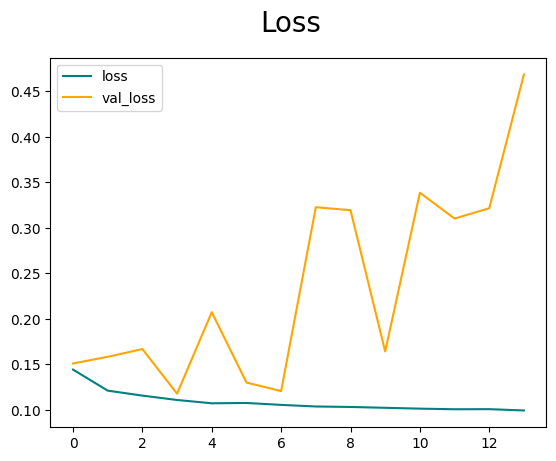

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

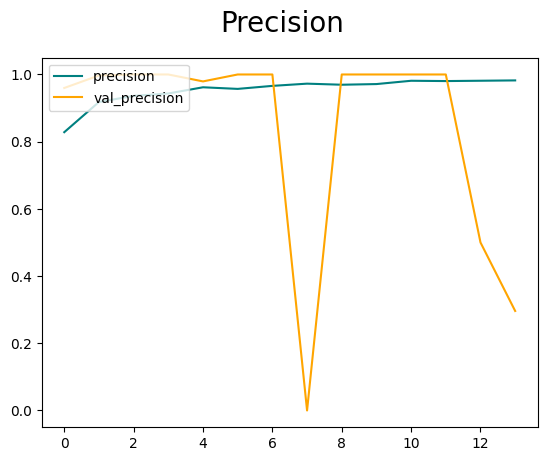

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='precision')
plt.plot(hist.history['val_precision'], color='orange', label='val_precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

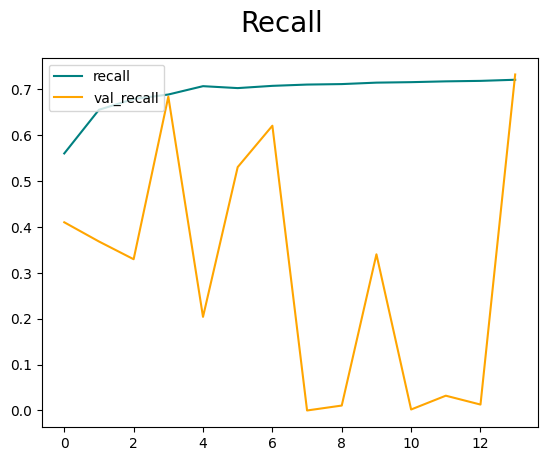

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
plt.plot(hist.history['val_recall'], color='orange', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

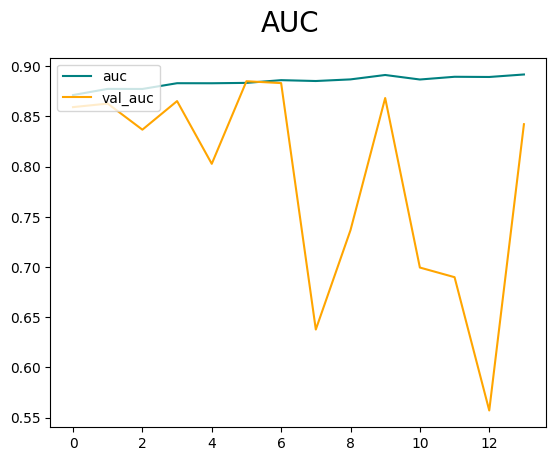

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['auc'], color='teal', label='auc')
plt.plot(hist.history['val_auc'], color='orange', label='val_auc')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tqdm import tqdm

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
tp = TruePositives()
tn = TrueNegatives()
fp = FalsePositives()
fn = FalseNegatives()

for i, batch in tqdm(enumerate(test_generator), total=len(test_generator)):
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    tp.update_state(y, yhat)
    tn.update_state(y, yhat)
    fp.update_state(y, yhat)
    fn.update_state(y, yhat)
    if(i>len(test_generator)):
     break

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Binary Accuracy:", acc.result().numpy())
print("True Positives:", tp.result().numpy())
print("True Negatives:", tn.result().numpy())
print("False Positives:", fp.result().numpy())
print("False Negatives:", fn.result().numpy())


  0%|          | 0/181 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  1%|          | 1/181 [00:03<10:58,  3.66s/it]

1/1 [==============================] - 0s 23ms/step


  1%|          | 2/181 [00:03<05:02,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/181 [00:04<03:08,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 4/181 [00:04<02:21,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 5/181 [00:05<01:51,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 6/181 [00:05<01:33,  1.88it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 7/181 [00:05<01:21,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 8/181 [00:06<01:18,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 9/181 [00:06<01:11,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 10/181 [00:06<01:06,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 11/181 [00:07<01:02,  2.73it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 12/181 [00:07<01:00,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 13/181 [00:07<01:02,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 14/181 [00:08<00:58,  2.88it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 15/181 [00:08<00:53,  3.09it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 16/181 [00:08<00:50,  3.24it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 17/181 [00:08<00:48,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 18/181 [00:09<00:47,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 19/181 [00:09<00:46,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 20/181 [00:09<00:49,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 21/181 [00:10<00:51,  3.13it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 22/181 [00:10<00:48,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 23/181 [00:10<00:46,  3.37it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 24/181 [00:11<00:49,  3.19it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 25/181 [00:11<00:46,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 26/181 [00:11<00:45,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 27/181 [00:12<00:47,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 28/181 [00:12<00:46,  3.28it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 29/181 [00:12<00:48,  3.12it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 30/181 [00:13<00:50,  3.00it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 31/181 [00:13<00:50,  2.95it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 32/181 [00:13<00:51,  2.89it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 33/181 [00:14<00:48,  3.04it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 34/181 [00:14<00:46,  3.14it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 35/181 [00:14<00:44,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 36/181 [00:14<00:43,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 37/181 [00:15<00:42,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 38/181 [00:15<00:41,  3.41it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 39/181 [00:15<00:40,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 40/181 [00:16<00:40,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 41/181 [00:16<00:39,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 42/181 [00:16<00:39,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 43/181 [00:16<00:39,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 44/181 [00:17<00:39,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 45/181 [00:17<00:38,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 46/181 [00:17<00:37,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 47/181 [00:18<00:39,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 48/181 [00:18<00:43,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 49/181 [00:18<00:45,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 50/181 [00:19<00:45,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 51/181 [00:19<00:44,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 52/181 [00:19<00:47,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 53/181 [00:20<00:45,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 54/181 [00:20<00:44,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 55/181 [00:20<00:43,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 56/181 [00:21<00:46,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 57/181 [00:21<00:41,  2.98it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 58/181 [00:21<00:39,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 59/181 [00:22<00:37,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 60/181 [00:22<00:36,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 61/181 [00:22<00:35,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 62/181 [00:23<00:34,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 63/181 [00:23<00:34,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 64/181 [00:23<00:33,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 65/181 [00:23<00:33,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 66/181 [00:24<00:35,  3.21it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 67/181 [00:24<00:34,  3.29it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 68/181 [00:24<00:33,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 69/181 [00:25<00:35,  3.18it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 70/181 [00:25<00:33,  3.27it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 71/181 [00:25<00:32,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 72/181 [00:26<00:34,  3.14it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 73/181 [00:26<00:33,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 74/181 [00:26<00:31,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 75/181 [00:26<00:30,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 76/181 [00:27<00:30,  3.40it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 77/181 [00:27<00:30,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 78/181 [00:27<00:29,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 79/181 [00:28<00:31,  3.28it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 80/181 [00:28<00:29,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 81/181 [00:28<00:31,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 82/181 [00:29<00:32,  3.07it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 83/181 [00:29<00:30,  3.18it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 84/181 [00:29<00:29,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 85/181 [00:29<00:28,  3.34it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 86/181 [00:30<00:28,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 87/181 [00:30<00:30,  3.13it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 88/181 [00:30<00:28,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 89/181 [00:31<00:27,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 90/181 [00:31<00:30,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 91/181 [00:32<00:32,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 92/181 [00:32<00:33,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 93/181 [00:32<00:32,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 94/181 [00:33<00:31,  2.78it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 95/181 [00:33<00:32,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 96/181 [00:33<00:31,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 97/181 [00:34<00:30,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 98/181 [00:34<00:29,  2.79it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 99/181 [00:34<00:27,  2.96it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 100/181 [00:35<00:25,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 101/181 [00:35<00:24,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 102/181 [00:35<00:24,  3.29it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 103/181 [00:36<00:23,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 104/181 [00:36<00:22,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 105/181 [00:36<00:23,  3.23it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 106/181 [00:37<00:24,  3.11it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 107/181 [00:37<00:22,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 108/181 [00:37<00:22,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 109/181 [00:37<00:21,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 110/181 [00:38<00:20,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 111/181 [00:38<00:20,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 112/181 [00:38<00:19,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 113/181 [00:38<00:19,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 114/181 [00:39<00:20,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 115/181 [00:39<00:19,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 116/181 [00:39<00:18,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 117/181 [00:40<00:18,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 118/181 [00:40<00:19,  3.23it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 119/181 [00:40<00:18,  3.29it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 120/181 [00:41<00:18,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 121/181 [00:41<00:17,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 122/181 [00:41<00:16,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 123/181 [00:41<00:16,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 124/181 [00:42<00:17,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 125/181 [00:42<00:17,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 126/181 [00:42<00:16,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 127/181 [00:43<00:15,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 128/181 [00:43<00:15,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 129/181 [00:43<00:15,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 130/181 [00:44<00:15,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 131/181 [00:44<00:14,  3.45it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 132/181 [00:44<00:15,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 133/181 [00:45<00:16,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 134/181 [00:45<00:15,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 135/181 [00:45<00:15,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 136/181 [00:46<00:14,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 137/181 [00:46<00:15,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 138/181 [00:46<00:14,  2.90it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 139/181 [00:47<00:15,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 140/181 [00:47<00:15,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 141/181 [00:47<00:14,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 142/181 [00:48<00:13,  2.90it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 143/181 [00:48<00:12,  3.10it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 144/181 [00:48<00:11,  3.16it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 145/181 [00:49<00:11,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 146/181 [00:49<00:10,  3.39it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 147/181 [00:49<00:09,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 148/181 [00:49<00:09,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 149/181 [00:50<00:09,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 150/181 [00:50<00:08,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 151/181 [00:50<00:08,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 152/181 [00:51<00:08,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 153/181 [00:51<00:07,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 154/181 [00:51<00:08,  3.32it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 155/181 [00:52<00:08,  3.20it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 156/181 [00:52<00:07,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 157/181 [00:52<00:07,  3.17it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 158/181 [00:52<00:07,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 159/181 [00:53<00:06,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 160/181 [00:53<00:06,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 161/181 [00:53<00:05,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 162/181 [00:54<00:05,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 163/181 [00:54<00:05,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 164/181 [00:54<00:05,  3.21it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 165/181 [00:55<00:04,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 166/181 [00:55<00:04,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 167/181 [00:55<00:04,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 168/181 [00:55<00:03,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 169/181 [00:56<00:03,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 170/181 [00:56<00:03,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 171/181 [00:56<00:02,  3.42it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 172/181 [00:57<00:02,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 173/181 [00:57<00:02,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 174/181 [00:57<00:01,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 175/181 [00:57<00:01,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 176/181 [00:58<00:01,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 177/181 [00:58<00:01,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 178/181 [00:59<00:01,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 179/181 [00:59<00:00,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 180/181 [00:59<00:00,  2.77it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 181/181 [01:03<00:00,  1.23s/it]

1/1 [==============================] - 0s 23ms/step


182it [01:03,  1.09it/s]                         

1/1 [==============================] - 0s 24ms/step


182it [01:03,  2.87it/s]


Precision: 0.32364342
Recall: 0.7803738
Binary Accuracy: 0.86419755
True Positives: 334.0
True Negatives: 4706.0
False Positives: 698.0
False Negatives: 94.0


In [ ]:
!cp /content/ResNet50LCC_model.h5 /content/drive/MyDrive/Licenta

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tqdm import tqdm

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tqdm import tqdm

model = tf.keras.models.load_model('/content/drive/MyDrive/Licenta/model_fold_1.h5')

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
tp = TruePositives()
tn = TrueNegatives()
fp = FalsePositives()
fn = FalseNegatives()

for i, batch in tqdm(enumerate(test_generator), total=len(test_generator)):
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    tp.update_state(y, yhat)
    tn.update_state(y, yhat)
    fp.update_state(y, yhat)
    fn.update_state(y, yhat)
    if(i>len(test_generator)):
     break

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Binary Accuracy:", acc.result().numpy())
print("True Positives:", tp.result().numpy())
print("True Negatives:", tn.result().numpy())
print("False Positives:", fp.result().numpy())
print("False Negatives:", fn.result().numpy())


  0%|          | 0/181 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  1%|          | 1/181 [00:06<20:13,  6.74s/it]

1/1 [==============================] - 3s 3s/step


  1%|          | 2/181 [00:10<14:25,  4.83s/it]

1/1 [==============================] - 3s 3s/step


  2%|▏         | 3/181 [00:13<12:22,  4.17s/it]

1/1 [==============================] - 5s 5s/step


  2%|▏         | 4/181 [00:19<14:07,  4.79s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 5/181 [00:22<12:35,  4.29s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 6/181 [00:26<11:31,  3.95s/it]

1/1 [==============================] - 3s 3s/step


  4%|▍         | 7/181 [00:29<11:02,  3.81s/it]

1/1 [==============================] - 5s 5s/step


  4%|▍         | 8/181 [00:35<12:31,  4.34s/it]

1/1 [==============================] - 3s 3s/step


  5%|▍         | 9/181 [00:38<11:36,  4.05s/it]

1/1 [==============================] - 3s 3s/step


  6%|▌         | 10/181 [00:41<11:01,  3.87s/it]

1/1 [==============================] - 4s 4s/step


  6%|▌         | 11/181 [00:45<11:04,  3.91s/it]

1/1 [==============================] - 5s 5s/step


  7%|▋         | 12/181 [00:50<11:51,  4.21s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 13/181 [00:54<11:04,  3.95s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 14/181 [00:57<10:38,  3.82s/it]

1/1 [==============================] - 5s 5s/step


  8%|▊         | 15/181 [01:03<11:51,  4.28s/it]

1/1 [==============================] - 4s 4s/step


  9%|▉         | 16/181 [01:07<11:45,  4.27s/it]

1/1 [==============================] - 3s 3s/step


  9%|▉         | 17/181 [01:10<11:02,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 10%|▉         | 18/181 [01:14<10:28,  3.85s/it]

1/1 [==============================] - 5s 5s/step


 10%|█         | 19/181 [01:19<11:47,  4.36s/it]

1/1 [==============================] - 3s 3s/step


 11%|█         | 20/181 [01:23<10:57,  4.08s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▏        | 21/181 [01:26<10:18,  3.87s/it]

1/1 [==============================] - 4s 4s/step


 12%|█▏        | 22/181 [01:31<11:26,  4.32s/it]

1/1 [==============================] - 4s 4s/step


 13%|█▎        | 23/181 [01:36<11:12,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 24/181 [01:39<10:30,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 25/181 [01:42<09:55,  3.82s/it]

1/1 [==============================] - 5s 5s/step


 14%|█▍        | 26/181 [01:48<11:00,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 27/181 [01:51<10:27,  4.07s/it]

1/1 [==============================] - 4s 4s/step


 15%|█▌        | 28/181 [01:55<10:27,  4.10s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 29/181 [01:59<09:51,  3.89s/it]

1/1 [==============================] - 5s 5s/step


 17%|█▋        | 30/181 [02:04<10:59,  4.37s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 31/181 [02:08<10:12,  4.08s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 32/181 [02:13<11:05,  4.47s/it]

1/1 [==============================] - 5s 5s/step


 18%|█▊        | 33/181 [02:19<11:49,  4.80s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 34/181 [02:22<10:49,  4.42s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 35/181 [02:26<09:58,  4.10s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 36/181 [02:31<10:49,  4.48s/it]

1/1 [==============================] - 4s 4s/step


 20%|██        | 37/181 [02:36<11:26,  4.76s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 38/181 [02:40<10:23,  4.36s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 39/181 [02:43<09:48,  4.14s/it]

1/1 [==============================] - 10s 10s/step


 22%|██▏       | 40/181 [02:54<14:14,  6.06s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 41/181 [02:58<12:26,  5.33s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 42/181 [03:01<11:00,  4.75s/it]

1/1 [==============================] - 5s 5s/step


 24%|██▍       | 43/181 [03:06<11:15,  4.89s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 44/181 [03:10<10:27,  4.58s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 45/181 [03:15<10:55,  4.82s/it]

1/1 [==============================] - 6s 6s/step


 25%|██▌       | 46/181 [03:26<14:44,  6.55s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 47/181 [03:30<12:34,  5.63s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 48/181 [03:33<10:59,  4.96s/it]

1/1 [==============================] - 5s 5s/step


 27%|██▋       | 49/181 [03:38<11:14,  5.11s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 50/181 [03:42<10:05,  4.62s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 51/181 [03:45<09:12,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▊       | 52/181 [03:49<08:33,  3.98s/it]

1/1 [==============================] - 6s 6s/step


 29%|██▉       | 53/181 [03:54<09:37,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 54/181 [03:58<08:47,  4.16s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 55/181 [04:01<08:13,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 56/181 [04:05<07:58,  3.83s/it]

1/1 [==============================] - 5s 5s/step


 31%|███▏      | 57/181 [04:10<08:57,  4.34s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 58/181 [04:14<08:19,  4.06s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 59/181 [04:17<07:50,  3.86s/it]

1/1 [==============================] - 4s 4s/step


 33%|███▎      | 60/181 [04:21<07:54,  3.92s/it]

1/1 [==============================] - 5s 5s/step


 34%|███▎      | 61/181 [04:26<08:24,  4.21s/it]

1/1 [==============================] - 3s 3s/step


 34%|███▍      | 62/181 [04:29<07:49,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▍      | 63/181 [04:33<07:22,  3.75s/it]

1/1 [==============================] - 4s 4s/step


 35%|███▌      | 64/181 [04:37<07:44,  3.97s/it]

1/1 [==============================] - 4s 4s/step


 36%|███▌      | 65/181 [04:41<07:57,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 36%|███▋      | 66/181 [04:45<07:27,  3.90s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 67/181 [04:48<07:04,  3.73s/it]

1/1 [==============================] - 5s 5s/step


 38%|███▊      | 68/181 [04:53<07:43,  4.11s/it]

1/1 [==============================] - 4s 4s/step


 38%|███▊      | 69/181 [04:57<07:34,  4.06s/it]

1/1 [==============================] - 3s 3s/step


 39%|███▊      | 70/181 [05:01<07:07,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 39%|███▉      | 71/181 [05:04<06:47,  3.70s/it]

1/1 [==============================] - 5s 5s/step


 40%|███▉      | 72/181 [05:09<07:36,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 40%|████      | 73/181 [05:13<07:14,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 41%|████      | 74/181 [05:16<06:48,  3.82s/it]

1/1 [==============================] - 3s 3s/step


 41%|████▏     | 75/181 [05:20<06:30,  3.68s/it]

1/1 [==============================] - 5s 5s/step


 42%|████▏     | 76/181 [05:25<07:23,  4.23s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 77/181 [05:28<06:55,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 78/181 [05:32<06:31,  3.81s/it]

1/1 [==============================] - 3s 3s/step


 44%|████▎     | 79/181 [05:35<06:13,  3.66s/it]

1/1 [==============================] - 5s 5s/step


 44%|████▍     | 80/181 [05:41<07:08,  4.24s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▍     | 81/181 [05:44<06:37,  3.97s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 82/181 [05:47<06:15,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 46%|████▌     | 83/181 [05:51<05:59,  3.67s/it]

1/1 [==============================] - 5s 5s/step


 46%|████▋     | 84/181 [05:57<06:53,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 47%|████▋     | 85/181 [06:00<06:23,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 86/181 [06:03<06:00,  3.80s/it]

1/1 [==============================] - 4s 4s/step


 48%|████▊     | 87/181 [06:07<05:57,  3.81s/it]

1/1 [==============================] - 5s 5s/step


 49%|████▊     | 88/181 [06:12<06:30,  4.20s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▉     | 89/181 [06:16<06:05,  3.98s/it]

1/1 [==============================] - 3s 3s/step


 50%|████▉     | 90/181 [06:19<05:46,  3.80s/it]

1/1 [==============================] - 4s 4s/step


 50%|█████     | 91/181 [06:23<05:59,  3.99s/it]

1/1 [==============================] - 4s 4s/step


 51%|█████     | 92/181 [06:28<06:09,  4.15s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████▏    | 93/181 [06:31<05:44,  3.91s/it]

1/1 [==============================] - 3s 3s/step


 52%|█████▏    | 94/181 [06:35<05:26,  3.75s/it]

1/1 [==============================] - 5s 5s/step


 52%|█████▏    | 95/181 [06:40<06:04,  4.24s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 96/181 [06:44<05:47,  4.09s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▎    | 97/181 [06:47<05:24,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▍    | 98/181 [06:53<05:58,  4.32s/it]

1/1 [==============================] - 4s 4s/step


 55%|█████▍    | 99/181 [06:57<05:52,  4.30s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▌    | 100/181 [07:00<05:26,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▌    | 101/181 [07:04<05:08,  3.86s/it]

1/1 [==============================] - 5s 5s/step


 56%|█████▋    | 102/181 [07:09<05:38,  4.29s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▋    | 103/181 [07:13<05:22,  4.14s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▋    | 104/181 [07:16<05:01,  3.91s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████▊    | 105/181 [07:19<04:44,  3.75s/it]

1/1 [==============================] - 5s 5s/step


 59%|█████▊    | 106/181 [07:25<05:23,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▉    | 107/181 [07:29<04:59,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 60%|█████▉    | 108/181 [07:32<04:40,  3.84s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████    | 109/181 [07:35<04:26,  3.70s/it]

1/1 [==============================] - 5s 5s/step


 61%|██████    | 110/181 [07:41<05:04,  4.29s/it]

1/1 [==============================] - 3s 3s/step


 61%|██████▏   | 111/181 [07:44<04:39,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 112/181 [07:48<04:23,  3.82s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 113/181 [07:51<04:15,  3.76s/it]

1/1 [==============================] - 6s 6s/step


 63%|██████▎   | 114/181 [07:58<05:04,  4.54s/it]

1/1 [==============================] - 4s 4s/step


 64%|██████▎   | 115/181 [08:02<05:02,  4.59s/it]

1/1 [==============================] - 3s 3s/step


 64%|██████▍   | 116/181 [08:06<04:35,  4.23s/it]

1/1 [==============================] - 4s 4s/step


 65%|██████▍   | 117/181 [08:10<04:33,  4.28s/it]

1/1 [==============================] - 4s 4s/step


 65%|██████▌   | 118/181 [08:15<04:34,  4.36s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████▌   | 119/181 [08:18<04:11,  4.06s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████▋   | 120/181 [08:21<03:55,  3.86s/it]

1/1 [==============================] - 5s 5s/step


 67%|██████▋   | 121/181 [08:27<04:18,  4.31s/it]

1/1 [==============================] - 3s 3s/step


 67%|██████▋   | 122/181 [08:30<04:03,  4.13s/it]

1/1 [==============================] - 3s 3s/step


 68%|██████▊   | 123/181 [08:34<03:46,  3.90s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▊   | 124/181 [08:37<03:32,  3.73s/it]

1/1 [==============================] - 5s 5s/step


 69%|██████▉   | 125/181 [08:43<04:01,  4.30s/it]

1/1 [==============================] - 3s 3s/step


 70%|██████▉   | 126/181 [08:46<03:41,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 70%|███████   | 127/181 [08:50<03:26,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 71%|███████   | 128/181 [08:53<03:15,  3.68s/it]

1/1 [==============================] - 5s 5s/step


 71%|███████▏  | 129/181 [08:58<03:41,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▏  | 130/181 [09:02<03:23,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▏  | 131/181 [09:05<03:10,  3.81s/it]

1/1 [==============================] - 4s 4s/step


 73%|███████▎  | 132/181 [09:09<03:06,  3.80s/it]

1/1 [==============================] - 5s 5s/step


 73%|███████▎  | 133/181 [09:14<03:21,  4.20s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 134/181 [09:18<03:05,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 135/181 [09:21<02:54,  3.79s/it]

1/1 [==============================] - 4s 4s/step


 75%|███████▌  | 136/181 [09:25<02:57,  3.94s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████▌  | 137/181 [09:30<03:03,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 138/181 [09:33<02:48,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 77%|███████▋  | 139/181 [09:37<02:37,  3.75s/it]

1/1 [==============================] - 4s 4s/step


 77%|███████▋  | 140/181 [09:41<02:42,  3.97s/it]

1/1 [==============================] - 4s 4s/step


 78%|███████▊  | 141/181 [09:46<02:44,  4.10s/it]

1/1 [==============================] - 3s 3s/step


 78%|███████▊  | 142/181 [09:49<02:31,  3.88s/it]

1/1 [==============================] - 3s 3s/step


 79%|███████▉  | 143/181 [09:52<02:21,  3.73s/it]

1/1 [==============================] - 5s 5s/step


 80%|███████▉  | 144/181 [09:58<02:35,  4.21s/it]

1/1 [==============================] - 3s 3s/step


 80%|████████  | 145/181 [10:01<02:26,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 146/181 [10:05<02:15,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 147/181 [10:08<02:05,  3.70s/it]

1/1 [==============================] - 5s 5s/step


 82%|████████▏ | 148/181 [10:14<02:20,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▏ | 149/181 [10:19<02:27,  4.60s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 150/181 [10:22<02:10,  4.21s/it]

1/1 [==============================] - 5s 5s/step


 83%|████████▎ | 151/181 [10:27<02:11,  4.38s/it]

1/1 [==============================] - 4s 4s/step


 84%|████████▍ | 152/181 [10:31<02:04,  4.30s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▍ | 153/181 [10:35<01:53,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▌ | 154/181 [10:38<01:43,  3.83s/it]

1/1 [==============================] - 5s 5s/step


 86%|████████▌ | 155/181 [10:43<01:51,  4.27s/it]

1/1 [==============================] - 3s 3s/step


 86%|████████▌ | 156/181 [10:47<01:42,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 87%|████████▋ | 157/181 [10:50<01:32,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 87%|████████▋ | 158/181 [10:54<01:25,  3.72s/it]

1/1 [==============================] - 5s 5s/step


 88%|████████▊ | 159/181 [10:59<01:34,  4.31s/it]

1/1 [==============================] - 3s 3s/step


 88%|████████▊ | 160/181 [11:05<01:36,  4.62s/it]

1/1 [==============================] - 3s 3s/step


 89%|████████▉ | 161/181 [11:08<01:24,  4.24s/it]

1/1 [==============================] - 5s 5s/step


 90%|████████▉ | 162/181 [11:13<01:25,  4.49s/it]

1/1 [==============================] - 4s 4s/step


 90%|█████████ | 163/181 [11:17<01:17,  4.30s/it]

1/1 [==============================] - 3s 3s/step


 91%|█████████ | 164/181 [11:20<01:08,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 91%|█████████ | 165/181 [11:24<01:01,  3.82s/it]

1/1 [==============================] - 5s 5s/step


 92%|█████████▏| 166/181 [11:29<01:03,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 167/181 [11:33<00:56,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 93%|█████████▎| 168/181 [11:36<00:49,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 93%|█████████▎| 169/181 [11:39<00:44,  3.69s/it]

1/1 [==============================] - 5s 5s/step


 94%|█████████▍| 170/181 [11:45<00:47,  4.29s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▍| 171/181 [11:48<00:40,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 95%|█████████▌| 172/181 [11:52<00:34,  3.81s/it]

1/1 [==============================] - 3s 3s/step


 96%|█████████▌| 173/181 [11:55<00:29,  3.69s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 174/181 [12:01<00:29,  4.25s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████▋| 175/181 [12:04<00:23,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████▋| 176/181 [12:07<00:18,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 98%|█████████▊| 177/181 [12:11<00:14,  3.72s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████▊| 178/181 [12:16<00:12,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▉| 179/181 [12:19<00:07,  3.91s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▉| 180/181 [12:23<00:03,  3.74s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 181/181 [12:24<00:00,  3.06s/it]

1/1 [==============================] - 5s 5s/step


182it [12:29,  3.63s/it]                         

1/1 [==============================] - 4s 4s/step


182it [12:33,  4.14s/it]

Precision: 0.15882353
Recall: 0.06013363
Binary Accuracy: 0.9031207
True Positives: 27.0
True Negatives: 5240.0
False Positives: 143.0
False Negatives: 422.0


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tqdm import tqdm

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tqdm import tqdm

model = tf.keras.models.load_model('/content/content/ModelTest')

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
tp = TruePositives()
tn = TrueNegatives()
fp = FalsePositives()
fn = FalseNegatives()

for i, batch in tqdm(enumerate(test_generator), total=len(test_generator)):
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    tp.update_state(y, yhat)
    tn.update_state(y, yhat)
    fp.update_state(y, yhat)
    fn.update_state(y, yhat)
    if(i>len(test_generator)):
     break

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Binary Accuracy:", acc.result().numpy())
print("True Positives:", tp.result().numpy())
print("True Negatives:", tn.result().numpy())
print("False Positives:", fp.result().numpy())
print("False Negatives:", fn.result().numpy())


  0%|          | 0/181 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  1%|          | 1/181 [00:10<32:42, 10.90s/it]

1/1 [==============================] - 3s 3s/step


  1%|          | 2/181 [00:14<19:08,  6.42s/it]

1/1 [==============================] - 4s 4s/step


  2%|▏         | 3/181 [00:19<17:32,  5.91s/it]

1/1 [==============================] - 4s 4s/step


  2%|▏         | 4/181 [00:23<15:00,  5.09s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 5/181 [00:26<12:59,  4.43s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 6/181 [00:31<13:45,  4.72s/it]

1/1 [==============================] - 5s 5s/step


  4%|▍         | 7/181 [00:37<14:16,  4.92s/it]

1/1 [==============================] - 3s 3s/step


  4%|▍         | 8/181 [00:40<12:40,  4.40s/it]

1/1 [==============================] - 3s 3s/step


  5%|▍         | 9/181 [00:43<11:34,  4.03s/it]

1/1 [==============================] - 4s 4s/step


  6%|▌         | 10/181 [00:48<12:00,  4.21s/it]

1/1 [==============================] - 4s 4s/step


  6%|▌         | 11/181 [00:52<11:56,  4.22s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 12/181 [00:57<12:49,  4.55s/it]

1/1 [==============================] - 4s 4s/step


  7%|▋         | 13/181 [01:03<13:22,  4.78s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 14/181 [01:08<13:47,  4.96s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 15/181 [01:11<12:16,  4.43s/it]

1/1 [==============================] - 4s 4s/step


  9%|▉         | 16/181 [01:17<12:54,  4.69s/it]

1/1 [==============================] - 3s 3s/step


  9%|▉         | 17/181 [01:22<13:22,  4.89s/it]

1/1 [==============================] - 3s 3s/step


 10%|▉         | 18/181 [01:25<11:54,  4.38s/it]

1/1 [==============================] - 4s 4s/step


 10%|█         | 19/181 [01:30<12:35,  4.66s/it]

1/1 [==============================] - 4s 4s/step


 11%|█         | 20/181 [01:36<13:05,  4.88s/it]

1/1 [==============================] - 4s 4s/step


 12%|█▏        | 21/181 [01:40<12:19,  4.62s/it]

1/1 [==============================] - 4s 4s/step


 12%|█▏        | 22/181 [01:45<12:48,  4.83s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 23/181 [01:51<13:09,  5.00s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 24/181 [01:54<11:43,  4.48s/it]

1/1 [==============================] - 4s 4s/step


 14%|█▍        | 25/181 [01:59<12:16,  4.72s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 26/181 [02:04<12:41,  4.91s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▍        | 27/181 [02:08<11:21,  4.43s/it]

1/1 [==============================] - 4s 4s/step


 15%|█▌        | 28/181 [02:12<11:11,  4.39s/it]

1/1 [==============================] - 5s 5s/step


 16%|█▌        | 29/181 [02:17<11:51,  4.68s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 30/181 [02:21<10:45,  4.28s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 31/181 [02:26<11:27,  4.59s/it]

1/1 [==============================] - 5s 5s/step


 18%|█▊        | 32/181 [02:31<11:57,  4.82s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 33/181 [02:37<12:14,  4.96s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 34/181 [02:42<12:27,  5.08s/it]

1/1 [==============================] - 8s 8s/step


 19%|█▉        | 35/181 [02:53<16:22,  6.73s/it]

1/1 [==============================] - 4s 4s/step


 20%|█▉        | 36/181 [02:58<15:13,  6.30s/it]

1/1 [==============================] - 4s 4s/step


 20%|██        | 37/181 [03:02<13:31,  5.64s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 38/181 [03:07<13:11,  5.53s/it]

1/1 [==============================] - 4s 4s/step


 22%|██▏       | 39/181 [03:11<11:58,  5.06s/it]

1/1 [==============================] - 5s 5s/step


 22%|██▏       | 40/181 [03:17<12:06,  5.15s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 41/181 [03:20<10:41,  4.58s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 42/181 [03:23<09:42,  4.19s/it]

1/1 [==============================] - 5s 5s/step


 24%|██▍       | 43/181 [03:28<10:06,  4.40s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▍       | 44/181 [03:32<09:51,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 45/181 [03:36<09:09,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 46/181 [03:41<09:55,  4.41s/it]

1/1 [==============================] - 5s 5s/step


 26%|██▌       | 47/181 [03:46<10:29,  4.70s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 48/181 [03:52<10:48,  4.88s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 49/181 [03:55<09:51,  4.48s/it]

1/1 [==============================] - 5s 5s/step


 28%|██▊       | 50/181 [04:00<10:21,  4.74s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 51/181 [04:06<10:38,  4.91s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▊       | 52/181 [04:09<09:31,  4.43s/it]

1/1 [==============================] - 5s 5s/step


 29%|██▉       | 53/181 [04:19<13:16,  6.22s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 54/181 [04:25<12:37,  5.96s/it]

1/1 [==============================] - 5s 5s/step


 30%|███       | 55/181 [04:30<12:18,  5.86s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 56/181 [04:36<11:51,  5.69s/it]

1/1 [==============================] - 3s 3s/step


 31%|███▏      | 57/181 [04:41<11:31,  5.58s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▏      | 58/181 [04:46<10:50,  5.29s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 59/181 [04:49<09:33,  4.70s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 60/181 [04:54<09:50,  4.88s/it]

1/1 [==============================] - 5s 5s/step


 34%|███▎      | 61/181 [05:00<10:02,  5.02s/it]

1/1 [==============================] - 3s 3s/step


 34%|███▍      | 62/181 [05:05<10:06,  5.10s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▍      | 63/181 [05:10<10:09,  5.16s/it]

1/1 [==============================] - 4s 4s/step


 35%|███▌      | 64/181 [05:15<09:36,  4.92s/it]

1/1 [==============================] - 3s 3s/step


 36%|███▌      | 65/181 [05:20<09:45,  5.05s/it]

1/1 [==============================] - 3s 3s/step


 36%|███▋      | 66/181 [05:25<09:49,  5.12s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 67/181 [05:29<08:56,  4.71s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 68/181 [05:34<09:12,  4.89s/it]

1/1 [==============================] - 4s 4s/step


 38%|███▊      | 69/181 [05:40<09:22,  5.02s/it]

1/1 [==============================] - 4s 4s/step


 39%|███▊      | 70/181 [05:44<08:42,  4.70s/it]

1/1 [==============================] - 3s 3s/step


 39%|███▉      | 71/181 [05:47<07:51,  4.28s/it]

1/1 [==============================] - 3s 3s/step


 40%|███▉      | 72/181 [05:50<07:17,  4.01s/it]

1/1 [==============================] - 5s 5s/step


 40%|████      | 73/181 [06:01<10:41,  5.94s/it]

1/1 [==============================] - 3s 3s/step


 41%|████      | 74/181 [06:06<10:16,  5.76s/it]

1/1 [==============================] - 5s 5s/step


 41%|████▏     | 75/181 [06:17<12:41,  7.18s/it]

1/1 [==============================] - 3s 3s/step


 42%|████▏     | 76/181 [06:20<10:32,  6.02s/it]

1/1 [==============================] - 5s 5s/step


 43%|████▎     | 77/181 [06:25<09:47,  5.64s/it]

1/1 [==============================] - 4s 4s/step


 43%|████▎     | 78/181 [06:29<08:54,  5.19s/it]

1/1 [==============================] - 3s 3s/step


 44%|████▎     | 79/181 [06:34<08:52,  5.22s/it]

1/1 [==============================] - 4s 4s/step


 44%|████▍     | 80/181 [06:38<08:14,  4.89s/it]

1/1 [==============================] - 5s 5s/step


 45%|████▍     | 81/181 [06:43<08:23,  5.03s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 82/181 [06:47<07:27,  4.52s/it]

1/1 [==============================] - 3s 3s/step


 46%|████▌     | 83/181 [06:50<06:46,  4.15s/it]

1/1 [==============================] - 5s 5s/step


 46%|████▋     | 84/181 [06:55<07:17,  4.51s/it]

1/1 [==============================] - 4s 4s/step


 47%|████▋     | 85/181 [07:01<07:38,  4.77s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 86/181 [07:06<07:48,  4.93s/it]

1/1 [==============================] - 6s 6s/step


 48%|████▊     | 87/181 [07:17<10:18,  6.58s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▊     | 88/181 [07:22<09:36,  6.20s/it]

1/1 [==============================] - 5s 5s/step


 49%|████▉     | 89/181 [07:27<09:10,  5.99s/it]

1/1 [==============================] - 3s 3s/step


 50%|████▉     | 90/181 [07:33<08:46,  5.78s/it]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 91/181 [07:36<07:35,  5.06s/it]

1/1 [==============================] - 5s 5s/step


 51%|█████     | 92/181 [07:46<09:53,  6.67s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████▏    | 93/181 [07:50<08:21,  5.70s/it]

1/1 [==============================] - 4s 4s/step


 52%|█████▏    | 94/181 [07:55<08:05,  5.58s/it]

1/1 [==============================] - 3s 3s/step


 52%|█████▏    | 95/181 [08:01<07:54,  5.52s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 96/181 [08:06<07:43,  5.46s/it]

1/1 [==============================] - 5s 5s/step


 54%|█████▎    | 97/181 [08:11<07:40,  5.49s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▍    | 98/181 [08:17<07:31,  5.44s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▍    | 99/181 [08:22<07:23,  5.41s/it]

1/1 [==============================] - 5s 5s/step


 55%|█████▌    | 100/181 [08:27<07:11,  5.33s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▌    | 101/181 [08:33<07:04,  5.31s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▋    | 102/181 [08:38<06:59,  5.31s/it]

1/1 [==============================] - 4s 4s/step


 57%|█████▋    | 103/181 [08:42<06:29,  4.99s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▋    | 104/181 [08:45<05:44,  4.47s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████▊    | 105/181 [08:51<05:59,  4.73s/it]

1/1 [==============================] - 5s 5s/step


 59%|█████▊    | 106/181 [08:56<06:08,  4.91s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▉    | 107/181 [09:01<06:11,  5.03s/it]

1/1 [==============================] - 3s 3s/step


 60%|█████▉    | 108/181 [09:07<06:13,  5.12s/it]

1/1 [==============================] - 4s 4s/step


 60%|██████    | 109/181 [09:12<06:14,  5.20s/it]

1/1 [==============================] - 3s 3s/step


 61%|██████    | 110/181 [09:17<06:11,  5.23s/it]

1/1 [==============================] - 5s 5s/step


 61%|██████▏   | 111/181 [09:28<07:54,  6.78s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 112/181 [09:33<07:17,  6.34s/it]

1/1 [==============================] - 5s 5s/step


 62%|██████▏   | 113/181 [09:44<08:35,  7.58s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 114/181 [09:47<07:02,  6.30s/it]

1/1 [==============================] - 5s 5s/step


 64%|██████▎   | 115/181 [09:52<06:30,  5.91s/it]

1/1 [==============================] - 4s 4s/step


 64%|██████▍   | 116/181 [09:56<05:43,  5.28s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▍   | 117/181 [09:59<04:58,  4.67s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▌   | 118/181 [10:02<04:28,  4.26s/it]

1/1 [==============================] - 5s 5s/step


 66%|██████▌   | 119/181 [10:08<04:43,  4.57s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████▋   | 120/181 [10:13<04:54,  4.83s/it]

1/1 [==============================] - 3s 3s/step


 67%|██████▋   | 121/181 [10:16<04:23,  4.40s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████▋   | 122/181 [10:22<04:35,  4.67s/it]

1/1 [==============================] - 3s 3s/step


 68%|██████▊   | 123/181 [10:27<04:42,  4.87s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▊   | 124/181 [10:32<04:44,  5.00s/it]

1/1 [==============================] - 5s 5s/step


 69%|██████▉   | 125/181 [10:38<04:50,  5.20s/it]

1/1 [==============================] - 3s 3s/step


 70%|██████▉   | 126/181 [10:43<04:47,  5.23s/it]

1/1 [==============================] - 3s 3s/step


 70%|███████   | 127/181 [10:49<04:43,  5.25s/it]

1/1 [==============================] - 5s 5s/step


 71%|███████   | 128/181 [10:54<04:40,  5.29s/it]

1/1 [==============================] - 5s 5s/step


 71%|███████▏  | 129/181 [10:59<04:35,  5.30s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▏  | 130/181 [11:05<04:30,  5.31s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████▏  | 131/181 [11:10<04:26,  5.33s/it]

1/1 [==============================] - 3s 3s/step


 73%|███████▎  | 132/181 [11:15<04:20,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 73%|███████▎  | 133/181 [11:26<05:28,  6.85s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 134/181 [11:31<04:59,  6.38s/it]

1/1 [==============================] - 5s 5s/step


 75%|███████▍  | 135/181 [11:41<05:50,  7.61s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 136/181 [11:47<05:11,  6.92s/it]

1/1 [==============================] - 5s 5s/step


 76%|███████▌  | 137/181 [11:52<04:44,  6.45s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 138/181 [11:57<04:22,  6.10s/it]

1/1 [==============================] - 3s 3s/step


 77%|███████▋  | 139/181 [12:03<04:06,  5.86s/it]

1/1 [==============================] - 4s 4s/step


 77%|███████▋  | 140/181 [12:08<03:54,  5.71s/it]

1/1 [==============================] - 3s 3s/step


 78%|███████▊  | 141/181 [12:13<03:43,  5.59s/it]

1/1 [==============================] - 5s 5s/step


 78%|███████▊  | 142/181 [12:19<03:36,  5.55s/it]

1/1 [==============================] - 3s 3s/step


 79%|███████▉  | 143/181 [12:24<03:28,  5.49s/it]

1/1 [==============================] - 3s 3s/step


 80%|███████▉  | 144/181 [12:29<03:21,  5.44s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████  | 145/181 [12:35<03:15,  5.43s/it]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 146/181 [12:38<02:47,  4.79s/it]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 147/181 [12:42<02:28,  4.37s/it]

1/1 [==============================] - 4s 4s/step


 82%|████████▏ | 148/181 [12:47<02:33,  4.65s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▏ | 149/181 [12:52<02:35,  4.86s/it]

1/1 [==============================] - 8s 8s/step


 83%|████████▎ | 150/181 [13:03<03:23,  6.56s/it]

1/1 [==============================] - 4s 4s/step


 83%|████████▎ | 151/181 [13:07<02:54,  5.81s/it]

1/1 [==============================] - 3s 3s/step


 84%|████████▍ | 152/181 [13:10<02:27,  5.09s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▍ | 153/181 [13:16<02:24,  5.16s/it]

1/1 [==============================] - 4s 4s/step


 85%|████████▌ | 154/181 [13:20<02:11,  4.88s/it]

1/1 [==============================] - 3s 3s/step


 86%|████████▌ | 155/181 [13:25<02:10,  5.02s/it]

1/1 [==============================] - 4s 4s/step


 86%|████████▌ | 156/181 [13:30<02:08,  5.13s/it]

1/1 [==============================] - 4s 4s/step


 87%|████████▋ | 157/181 [13:36<02:05,  5.22s/it]

1/1 [==============================] - 3s 3s/step


 87%|████████▋ | 158/181 [13:39<01:48,  4.70s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████▊ | 159/181 [13:44<01:41,  4.62s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████▊ | 160/181 [13:49<01:41,  4.86s/it]

1/1 [==============================] - 3s 3s/step


 89%|████████▉ | 161/181 [13:55<01:40,  5.01s/it]

1/1 [==============================] - 4s 4s/step


 90%|████████▉ | 162/181 [14:00<01:37,  5.11s/it]

1/1 [==============================] - 3s 3s/step


 90%|█████████ | 163/181 [14:05<01:33,  5.19s/it]

1/1 [==============================] - 3s 3s/step


 91%|█████████ | 164/181 [14:09<01:19,  4.65s/it]

1/1 [==============================] - 4s 4s/step


 91%|█████████ | 165/181 [14:13<01:11,  4.48s/it]

1/1 [==============================] - 5s 5s/step


 92%|█████████▏| 166/181 [14:18<01:11,  4.75s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 167/181 [14:22<01:00,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 93%|█████████▎| 168/181 [14:27<01:00,  4.62s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████▎| 169/181 [14:32<00:57,  4.77s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▍| 170/181 [14:35<00:47,  4.35s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▍| 171/181 [14:41<00:46,  4.65s/it]

1/1 [==============================] - 6s 6s/step


 95%|█████████▌| 172/181 [14:51<00:57,  6.40s/it]

1/1 [==============================] - 3s 3s/step


 96%|█████████▌| 173/181 [14:57<00:48,  6.10s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████▌| 174/181 [15:02<00:41,  5.87s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████▋| 175/181 [15:05<00:30,  5.10s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████▋| 176/181 [15:11<00:25,  5.17s/it]

1/1 [==============================] - 6s 6s/step


 98%|█████████▊| 177/181 [15:21<00:27,  6.76s/it]

1/1 [==============================] - 3s 3s/step


 98%|█████████▊| 178/181 [15:26<00:19,  6.34s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 179/181 [15:29<00:10,  5.20s/it]

1/1 [==============================] - 4s 4s/step


 99%|█████████▉| 180/181 [15:34<00:05,  5.25s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 181/181 [15:40<00:00,  5.26s/it]

1/1 [==============================] - 5s 5s/step


182it [15:45,  5.29s/it]                         

1/1 [==============================] - 4s 4s/step


182it [15:50,  5.22s/it]

Precision: 0.96198833
Recall: 0.74603176
Binary Accuracy: 0.9785665
True Positives: 329.0
True Negatives: 5378.0
False Positives: 13.0
False Negatives: 112.0


In [ ]:
!unzip /content/drive/MyDrive/Licenta/ModelTest.zip -d /content/content

Archive:  /content/drive/MyDrive/Licenta/ModelTest.zip
   creating: /content/content/ModelTest/assets/
 extracting: /content/content/ModelTest/fingerprint.pb  
  inflating: /content/content/ModelTest/keras_metadata.pb  
  inflating: /content/content/ModelTest/saved_model.pb  
   creating: /content/content/ModelTest/variables/
  inflating: /content/content/ModelTest/variables/variables.data-00000-of-00001  
  inflating: /content/content/ModelTest/variables/variables.index  
